In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [56]:
import platform

# 운영 체제 정보 확인
os_info = platform.platform()

# 파이썬 버전 확인
python_version = platform.python_version()

print("운영 체제:", os_info)
print("파이썬 버전:", python_version)


운영 체제: Linux-5.15.120+-x86_64-with-glibc2.35
파이썬 버전: 3.10.12


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from scipy.stats import ranksums

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier, CatBoostRegressor

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import random
from collections import Counter

import pickle

import warnings
warnings.filterwarnings(action = 'ignore')

In [5]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/GBT 해커톤/train.csv')
test = pd.read_csv('/content/drive/MyDrive/GBT 해커톤/test.csv')

In [6]:
print(train.shape)
print(test.shape)

(14095, 54)
(6041, 19)


In [7]:
# 변수 보기
print(train.columns.values)
print()
print(test.columns.values)

['ID' 'COMPONENT_ARBITRARY' 'ANONYMOUS_1' 'YEAR' 'SAMPLE_TRANSFER_DAY'
 'ANONYMOUS_2' 'AG' 'AL' 'B' 'BA' 'BE' 'CA' 'CD' 'CO' 'CR' 'CU' 'FH2O'
 'FNOX' 'FOPTIMETHGLY' 'FOXID' 'FSO4' 'FTBN' 'FE' 'FUEL' 'H2O' 'K' 'LI'
 'MG' 'MN' 'MO' 'NA' 'NI' 'P' 'PB' 'PQINDEX' 'S' 'SB' 'SI' 'SN'
 'SOOTPERCENTAGE' 'TI' 'U100' 'U75' 'U50' 'U25' 'U20' 'U14' 'U6' 'U4' 'V'
 'V100' 'V40' 'ZN' 'Y_LABEL']

['ID' 'COMPONENT_ARBITRARY' 'ANONYMOUS_1' 'YEAR' 'ANONYMOUS_2' 'AG' 'CO'
 'CR' 'CU' 'FE' 'H2O' 'MN' 'MO' 'NI' 'PQINDEX' 'TI' 'V' 'V40' 'ZN']


In [8]:
tr = list(train.columns.values)
te = list(test.columns.values)
drop_features = [item for item in tr if item not in te]
drop_features.remove('Y_LABEL')
print(drop_features)

['SAMPLE_TRANSFER_DAY', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K', 'LI', 'MG', 'NA', 'P', 'PB', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


In [9]:
#train = train.drop(drop_features, axis=1)

In [10]:
#train = train.drop('ID', axis=1)
#test = test.drop('ID', axis=1)

In [11]:
print(train.columns.values)
print()
print(test.columns.values)

['ID' 'COMPONENT_ARBITRARY' 'ANONYMOUS_1' 'YEAR' 'SAMPLE_TRANSFER_DAY'
 'ANONYMOUS_2' 'AG' 'AL' 'B' 'BA' 'BE' 'CA' 'CD' 'CO' 'CR' 'CU' 'FH2O'
 'FNOX' 'FOPTIMETHGLY' 'FOXID' 'FSO4' 'FTBN' 'FE' 'FUEL' 'H2O' 'K' 'LI'
 'MG' 'MN' 'MO' 'NA' 'NI' 'P' 'PB' 'PQINDEX' 'S' 'SB' 'SI' 'SN'
 'SOOTPERCENTAGE' 'TI' 'U100' 'U75' 'U50' 'U25' 'U20' 'U14' 'U6' 'U4' 'V'
 'V100' 'V40' 'ZN' 'Y_LABEL']

['ID' 'COMPONENT_ARBITRARY' 'ANONYMOUS_1' 'YEAR' 'ANONYMOUS_2' 'AG' 'CO'
 'CR' 'CU' 'FE' 'H2O' 'MN' 'MO' 'NI' 'PQINDEX' 'TI' 'V' 'V40' 'ZN']


In [12]:
train.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,-0.996688,2011,7,-1.000000,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,1
1,TRAIN_00001,COMPONENT2,-0.997615,2021,51,-0.962963,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,-0.990356,2015,2,-1.000000,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,0
3,TRAIN_00003,COMPONENT3,-0.956456,2010,2,-1.000000,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,-0.979867,2015,4,-1.000000,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0


In [13]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,-0.995011,2014,-1.00000,0,0,3,43,45,0.0,2,0,0,15,0,0,85.5,1007
1,TEST_0001,COMPONENT3,-0.984052,2015,-1.00000,0,0,0,0,165,0.0,1,0,1,62,0,0,155.5,35
2,TEST_0002,COMPONENT3,-0.977618,2021,-0.90328,0,0,1,12,101,0.0,16,1,0,158,0,0,46.8,1480
3,TEST_0003,COMPONENT1,-0.988407,2010,-1.00000,0,0,6,7,66,0.0,1,167,3,14,0,0,109.9,1023
4,TEST_0004,COMPONENT2,-0.985626,2017,-1.00000,0,0,0,5,3,0.0,0,0,0,8,0,0,46.8,377


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  float64
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  float64
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   object 
 2   ANONYMOUS_1          6041 non-null   float64
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   float64
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

In [16]:
def bar_chart(feature):
    normal = train.loc[train["Y_LABEL"]==0,feature].value_counts()  #해당 특징의 Y_LABEL이 1인 갯수를 세어준다.
    abnormal = train.loc[train["Y_LABEL"]==1,feature].value_counts()
    data = pd.DataFrame([normal,abnormal],index = ["normal","abnormal"])
    data.plot(kind="bar",figsize=(15,10))
    plt.show()

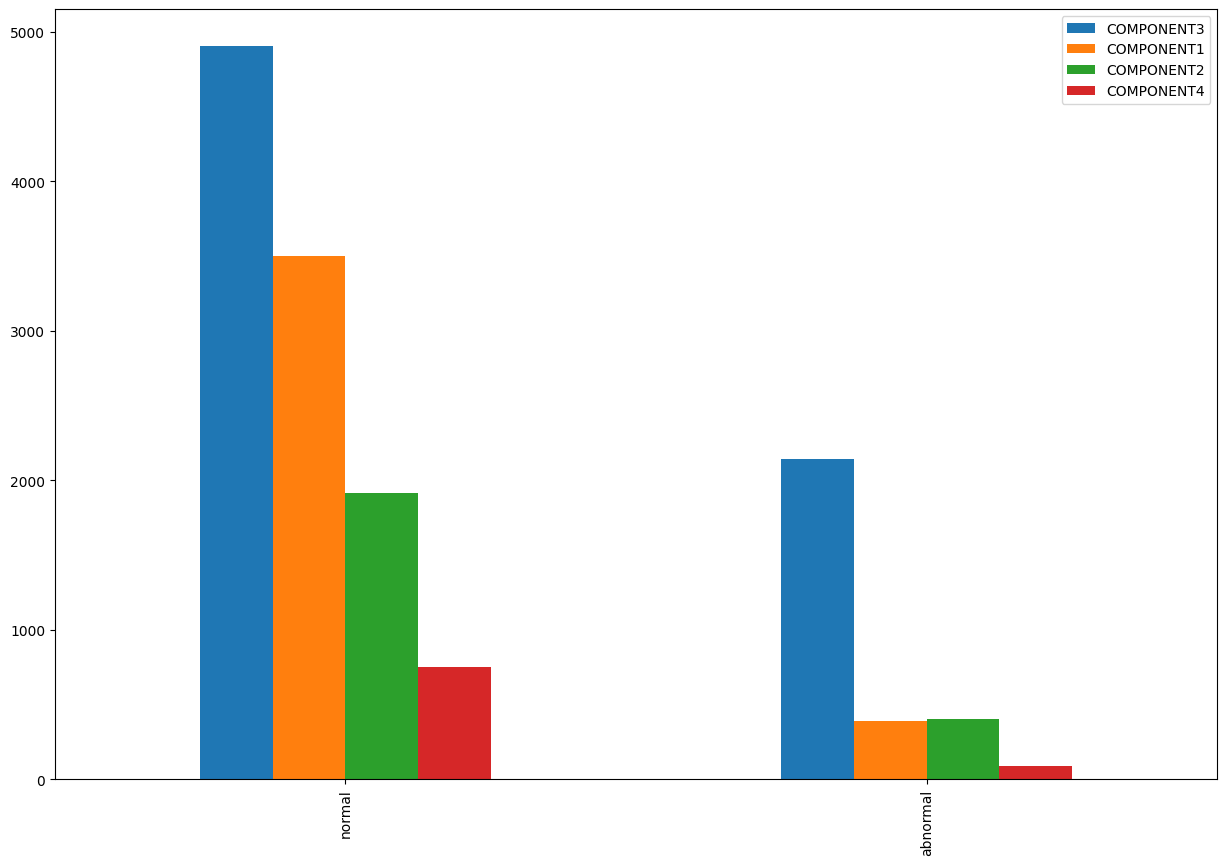

In [17]:
bar_chart('COMPONENT_ARBITRARY')

In [18]:
#COMPONENT_ARBITRARY을 숫자로 매핑
train['COMPONENT_ARBITRARY'] = train['COMPONENT_ARBITRARY'].map({'COMPONENT1': 1, 'COMPONENT2': 2, 'COMPONENT3': 3, 'COMPONENT4': 4})
test['COMPONENT_ARBITRARY'] = test['COMPONENT_ARBITRARY'].map({'COMPONENT1': 1, 'COMPONENT2': 2, 'COMPONENT3': 3, 'COMPONENT4': 4})

In [19]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,1,-0.995011,2014,-1.00000,0,0,3,43,45,0.0,2,0,0,15,0,0,85.5,1007
1,TEST_0001,3,-0.984052,2015,-1.00000,0,0,0,0,165,0.0,1,0,1,62,0,0,155.5,35
2,TEST_0002,3,-0.977618,2021,-0.90328,0,0,1,12,101,0.0,16,1,0,158,0,0,46.8,1480
3,TEST_0003,1,-0.988407,2010,-1.00000,0,0,6,7,66,0.0,1,167,3,14,0,0,109.9,1023
4,TEST_0004,2,-0.985626,2017,-1.00000,0,0,0,5,3,0.0,0,0,0,8,0,0,46.8,377


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   int64  
 2   ANONYMOUS_1          6041 non-null   float64
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   float64
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  int64  
 2   ANONYMOUS_1          14095 non-null  float64
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  float64
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [22]:
#correlation = train.corr()['Y_LABEL']
#print(correlation)

In [23]:
# 결측치가 있는 변수 개수 파악
mis_val = train.isnull().sum()
print(mis_val)
mis_val_bool = mis_val >= 1
mis_val_df = pd.concat([mis_val, mis_val_bool], axis = 1)
mis_val_df = mis_val_df.rename(columns = {0 : 'mis_val', 1 : 'mis_val_bool'})

print()
print("결측이 변수")
print(mis_val_df['mis_val_bool'].value_counts())

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

In [24]:
# 결측치가 있는 변수 및 결측률 파악

mis_val_data = mis_val_df.loc[mis_val_df['mis_val_bool'] == True, :]
mis_val_data['ratio'] = mis_val_data['mis_val'] / 14095
mis_val_data

,mis_val,mis_val_bool,ratio
CD,1394,True,0.098900
FH2O,10205,True,0.724016
FNOX,10205,True,0.724016
FOPTIMETHGLY,10205,True,0.724016
FOXID,10205,True,0.724016
FSO4,10205,True,0.724016
FTBN,10205,True,0.724016
FUEL,10205,True,0.724016
K,2299,True,0.163107
SOOTPERCENTAGE,10205,True,0.724016


In [25]:
# 결측률이 20% 이상인 변수들 제거

notnull_columns = train.loc[:, train.notnull().sum(axis = 0) == 14095].columns
notnull_columns = notnull_columns[1 :]
notnull_columns = list(notnull_columns)

select_columns = notnull_columns[: 32] + ['K', 'CD'] + notnull_columns[32 :]
train2 = train.loc[:, select_columns]
print(train2.shape)
#print(train.columns)
print(train2.columns)

(14095, 36)
Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'SAMPLE_TRANSFER_DAY',
       'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CO', 'CR', 'CU',
       'FE', 'H2O', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX',
       'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'K', 'CD', 'ZN', 'Y_LABEL'],
      dtype='object')


In [26]:
# train 데이터, test 데이터에 모두 포함되어 있는 변수 18개의 상관관계 분석

t = train2.copy()
corr = t.corr()
corr.style.background_gradient(cmap = 'coolwarm')

# TI와 V : 0.678
# FE와 SI : 0.649
# NI와 SI : 0.630
# FE와 MN : 0.622
# S와 V40 : 0.607
# SI와 TI : 0.606
# SI와 K : 0.605
# MN와 TI : 0.585
# FE와 NI : 0.583
# MN와 SI : 0.554
# CO와 FE : 0.537
# MN와 NI : 0.583
# TI와 K : 0.524
# MN와 K : 0.511

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CO,CR,CU,FE,H2O,LI,MG,MN,MO,NA,NI,P,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,K,CD,ZN,Y_LABEL
COMPONENT_ARBITRARY,1.000000,0.020564,-0.001697,-0.012237,-0.000554,-0.000846,-0.000147,0.011580,0.002327,-0.023412,0.008349,0.031651,0.038158,0.116958,0.198611,0.026319,0.056370,-0.213497,0.149146,-0.346053,0.031202,0.109050,0.087985,-0.056745,0.178434,0.494369,0.026499,0.093708,-0.162266,0.065816,0.041598,0.225840,-0.007503,0.023840,-0.542198,0.163196
ANONYMOUS_1,0.020564,1.000000,0.106546,-0.041395,0.072154,-0.025674,0.017924,0.013467,-0.064204,-0.010805,-0.015321,-0.003783,-0.007035,-0.014086,0.000440,0.003868,0.000944,-0.001807,-0.004212,-0.006206,0.000183,-0.007862,-0.013647,-0.000499,0.002277,0.016374,-0.011797,0.005141,-0.009564,0.001832,0.001883,0.019542,-0.004384,0.010076,-0.019991,0.003938
YEAR,-0.001697,0.106546,1.000000,-0.094086,0.138199,-0.129124,-0.017525,0.011145,-0.098589,-0.063859,0.090465,-0.052337,-0.028871,-0.137593,-0.057709,0.009855,0.002697,0.025616,-0.039132,-0.091482,0.028953,-0.049206,-0.143675,-0.031021,-0.067160,-0.141084,-0.019612,0.011831,-0.065335,0.006399,-0.027624,-0.051584,-0.032801,-0.012668,0.048572,-0.053321
SAMPLE_TRANSFER_DAY,-0.012237,-0.041395,-0.094086,1.000000,-0.000060,0.021211,-0.017493,0.004305,0.016909,0.009600,0.008826,0.002195,-0.001495,0.006303,0.011651,-0.007926,-0.002275,0.008802,0.006816,0.001051,-0.006263,0.015599,-0.009730,0.000543,0.033622,0.014327,-0.015647,0.007713,0.006986,-0.002855,-0.002412,0.013896,0.012344,-0.006108,-0.019428,-0.000327
ANONYMOUS_2,-0.000554,0.072154,0.138199,-0.000060,1.000000,-0.006266,-0.022788,-0.100307,-0.011871,0.011162,-0.043046,-0.000070,-0.001826,-0.002244,-0.004608,-0.003760,-0.002483,-0.003306,0.003304,-0.008465,0.000647,-0.003914,0.000771,0.000519,-0.010409,-0.033153,0.006001,0.007633,0.004799,-0.000981,-0.006469,-0.025339,-0.003246,0.012702,0.032758,-0.000547
AG,-0.000846,-0.025674,-0.129124,0.021211,-0.006266,1.000000,0.019600,-0.028131,0.031649,0.020884,-0.004489,0.008861,0.005397,0.051046,0.025959,-0.003850,0.002394,-0.009523,0.019507,0.013124,-0.007197,0.054014,0.024517,0.020716,0.030929,0.017271,0.028327,0.020739,0.016582,0.003609,-0.003853,0.013592,0.013082,0.004325,0.002631,0.024032
AL,-0.000147,0.017924,-0.017525,-0.017493,-0.022788,0.019600,1.000000,0.000037,0.240863,-0.000858,-0.070322,0.009920,0.011430,0.037530,0.051138,-0.000093,0.000008,-0.001625,0.033695,-0.002615,-0.002290,0.099946,-0.022301,-0.004914,0.030492,0.011343,0.003998,0.087274,-0.006664,0.062613,0.026213,0.013823,0.037586,-0.004580,-0.024873,0.041619
B,0.011580,0.013467,0.011145,0.004305,-0.100307,-0.028131,0.000037,1.000000,-0.045454,-0.013252,0.356121,0.005536,0.003759,0.000142,0.003075,-0.005442,0.015888,0.003456,0.000792,-0.001100,0.004937,0.010686,-0.004137,0.008009,-0.003177,0.005926,-0.019423,0.004165,-0.000990,0.008712,0.018197,-0.000882,-0.004724,-0.018408,-0.006463,0.003901
BA,0.002327,-0.064204,-0.098589,0.016909,-0.011871,0.031649,0.240863,-0.045454,1.000000,0.029900,-0.008642,0.004970,0.000443,0.023212,0.012627,-0.005055,-0.005337,-0.006470,0.007149,-0.004351,-0.004076,0.018465,0.003426,0.000497,0.003411,0.013244,0.006005,0.010588,0.004767,0.005074,0.000480,0.004150,0.007964,-0.001110,-0.009574,0.008386
BE,-0.023412,-0.010805,-0.063859,0.009600,0.011162,0.020884,-0.000858,-0.013252,0.029900,1.000000,0.006735,0.014084,0.002712,-0.001388,0.002707,-0.001610,-0.000977,0.045744,-0.000759,0.000208,-0.005445,0.001227,0.024291,0.006927,-0.000746,0.002929,0.007266,-0.002948,0.025744,-0.002501,0.000482,0.001359,0.003115,-0.002690,0.012394,-0.003514


In [27]:
# IQR을 이용하여 정상 범위 추출하기

def IQR_outlier(data) :
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    return pd.concat([lower_bound, upper_bound], axis = 1).T

In [28]:
# 정상 범위와 이상 범위의 데이터 간 윌콕슨 순위합 검정 실시

ranksum_p = []
variable_17 = ['SAMPLE_TRANSFER_DAY', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'K', 'LI', 'MG', 'NA', 'P', 'PB', 'S', 'SB', 'SI', 'SN']

# alternative = 'greater'을 걸어줘서 한쪽 검정으로 실시
# scipy 1.8.1 버전 이상이어야 ranksums의 옵션인 alternative(한쪽 검정) 사용 가능
for v in variable_17 :
    temp = ranksums(train.loc[(train['Y_LABEL'] == 1) & (train[v].notnull()), v],
                  train.loc[(train['Y_LABEL'] == 0) & (train[v].notnull()), v],
                  alternative = 'greater').pvalue
    ranksum_p.append(temp)

Wilcoxon_var_table = pd.DataFrame({'variable' : variable_17,
                                   'p_value' : ranksum_p,
                                   'p_value_round' : np.round(ranksum_p, 4)})
Wilcoxon_var_table.sort_values('p_value')

,variable,p_value,p_value_round
15,SI,0.000000e+00,0.0000
13,S,1.970075e-120,0.0000
7,K,1.599942e-50,0.0000
10,NA,5.842989e-36,0.0000
8,LI,2.692208e-09,0.0000
1,AL,2.754589e-07,0.0000
14,SB,8.675096e-05,0.0001
16,SN,3.476822e-04,0.0003
3,BA,2.889683e-02,0.0289
6,CD,3.676709e-01,0.3677


In [29]:
# P_value가 0.05 이하인 변수만 추출
Wilcoxon_var_table.loc[Wilcoxon_var_table['p_value'] <= 0.05, :].sort_values('p_value')

,variable,p_value,p_value_round
15,SI,0.000000e+00,0.0000
13,S,1.970075e-120,0.0000
7,K,1.599942e-50,0.0000
10,NA,5.842989e-36,0.0000
8,LI,2.692208e-09,0.0000
1,AL,2.754589e-07,0.0000
14,SB,8.675096e-05,0.0001
16,SN,3.476822e-04,0.0003
3,BA,2.889683e-02,0.0289


In [30]:
Wilcoxon_var_table.loc[Wilcoxon_var_table['p_value'] <= 0.05, 'variable']

1     AL
3     BA
7      K
8     LI
10    NA
13     S
14    SB
15    SI
16    SN
Name: variable, dtype: object

In [31]:
# 각 변수에 대해 '정상 범위 데이터 개수', '이상 범위 데이터 개수', '전체 데이터 합계',
#               '정상 범위 데이터의 불량 개수', '이상 범위 데이터의 불량 개수', '불량 합계',
#               '정상 범위 데이터의 불량률', '이상 범위 데이터의 불량률'
# 에 대한 Table 생성

variable_7 = ['AL', 'BA', 'K', 'S', 'SB', 'SI', 'SN']

outlier_table = pd.DataFrame(np.zeros([8, len(variable_7)]), columns = variable_7,
                             index = ['정상 범위 데이터 개수', '이상 범위 데이터 개수', '전체 데이터 합계',
                                      '정상 범위 데이터의 불량 개수', '이상 범위 데이터의 불량 개수', '불량 합계',
                                      '정상 범위 데이터의 불량률', '이상 범위 데이터의 불량률'])

for v in variable_7 :
    temp1 = train2.loc[(IQR_outlier(train2).loc[0, v] <= train2[v]) &
                        (train2[v] <= IQR_outlier(train2).loc[1, v]), :]
    temp2 = train2.loc[(IQR_outlier(train2).loc[0, v] > train2[v]) | (train2[v] > IQR_outlier(train2).loc[1, v]), :]

    outlier_table.at['정상 범위 데이터 개수', v] = temp1.shape[0]
    outlier_table.at['이상 범위 데이터 개수', v] = temp2.shape[0]
    outlier_table.at['전체 데이터 합계', v] = temp1.shape[0] + temp2.shape[0]

    temp3 = temp1.loc[train2['Y_LABEL'] == 1, :]
    temp4 = temp2.loc[train2['Y_LABEL'] == 1, :]
    outlier_table.at['정상 범위 데이터의 불량 개수', v] = temp3.shape[0]
    outlier_table.at['이상 범위 데이터의 불량 개수', v] = temp4.shape[0]
    outlier_table.at['불량 합계', v] = temp3.shape[0] + temp4.shape[0]

    if temp1.shape[0] == 0 :
        temp5 = 0
    else :
        temp5 = np.round(temp3.shape[0] / temp1.shape[0] * 100, 3)
    outlier_table.at['정상 범위 데이터의 불량률', v] = temp5

    if temp2.shape[0] == 0 :
        temp6 = 0
    else :
        temp6 = np.round(temp4.shape[0] / temp2.shape[0] * 100, 3)
    outlier_table.at['이상 범위 데이터의 불량률', v] = temp6

outlier_table = outlier_table.T

In [32]:
outlier_table.nlargest(len(variable_17), columns = ['이상 범위 데이터의 불량 개수'])

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
SI,12246.0,1849.0,14095.0,1937.0,1087.0,3024.0,15.817,58.789
BA,10780.0,3315.0,14095.0,2258.0,766.0,3024.0,20.946,23.107
SB,11128.0,2967.0,14095.0,2287.0,737.0,3024.0,20.552,24.840
K,10738.0,1058.0,11796.0,1879.0,468.0,2347.0,17.499,44.234
AL,12651.0,1444.0,14095.0,2626.0,398.0,3024.0,20.757,27.562
SN,12778.0,1317.0,14095.0,2702.0,322.0,3024.0,21.146,24.450
S,14088.0,7.0,14095.0,3017.0,7.0,3024.0,21.415,100.000


In [33]:
outlier_table.nlargest(len(variable_17), columns = ['이상 범위 데이터의 불량률'])

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
S,14088.0,7.0,14095.0,3017.0,7.0,3024.0,21.415,100.000
SI,12246.0,1849.0,14095.0,1937.0,1087.0,3024.0,15.817,58.789
K,10738.0,1058.0,11796.0,1879.0,468.0,2347.0,17.499,44.234
AL,12651.0,1444.0,14095.0,2626.0,398.0,3024.0,20.757,27.562
SB,11128.0,2967.0,14095.0,2287.0,737.0,3024.0,20.552,24.840
SN,12778.0,1317.0,14095.0,2702.0,322.0,3024.0,21.146,24.450
BA,10780.0,3315.0,14095.0,2258.0,766.0,3024.0,20.946,23.107


In [34]:
variable = variable_7

target_var = []

for v in variable :

    print(v)

    LB = IQR_outlier(train).loc[0, v]
    RB = IQR_outlier(train).loc[1, v]
    Defect_Q50 = train.loc[(train['Y_LABEL'] == 1) & (train[v].notnull()), v].quantile(0.5)

    print(LB, Defect_Q50, RB)

    if (Defect_Q50 < LB) or (Defect_Q50 > RB) :
        target_var.append(v)
    else :
        continue

AL
-3.5 2.0 8.5
BA
0.0 0.0 0.0
K
-4.5 2.0 7.5
S
-18523.75 16225.0 42714.25
SB
0.0 0.0 0.0
SI
-10.5 13.0 25.5
SN
-1.5 0.0 2.5


In [35]:
#target_var = []
#target_var.append('AL')
#target_var.append('BA')
target_var

[]

In [36]:
train1 = train.copy()
test1 = test.copy()

In [37]:
train2 = train1.loc[:, ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
                                        'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
                                        'V40', 'ZN', 'Y_LABEL', 'AL', 'BA']]
test2 = test1.drop(['ID'], axis = 1)

print(train2.shape)
print(test2.shape)

(14095, 21)
(6041, 18)


In [38]:
# 범주형 변수인 COMPONENT_ARBITRARY와 YEAR를 LabelEncoder 변환

le1 = LabelEncoder()
le2 = LabelEncoder()

train2['COMPONENT_ARBITRARY_category'] = le1.fit_transform(train2['COMPONENT_ARBITRARY'])
train2['YEAR_category'] = le2.fit_transform(train2['YEAR'])

test2['COMPONENT_ARBITRARY_category'] = le1.transform(test2['COMPONENT_ARBITRARY'])
test2['YEAR_category'] = le2.transform(test2['YEAR'])

# 원래 범주형 변수는 제거해준다.
train3 = train2.drop(['COMPONENT_ARBITRARY', 'YEAR'], axis = 1)
test3 = test2.drop(['COMPONENT_ARBITRARY', 'YEAR'], axis = 1)

categorical_features = ['COMPONENT_ARBITRARY_category', 'YEAR_category']

print(train3.shape)
print(test3.shape)

(14095, 21)
(6041, 18)


In [39]:
# 교차 검증을 위해 X_train을 X_partrain과 X_val로 분할
# stratify 옵션을 사용하여 y의 정상, 불량 비율에 맞게 분할

X_train = train3.drop(['Y_LABEL'], axis = 1)
y_train = train3['Y_LABEL']
X_test = test3

X_partrain, X_val, y_partrain, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 39, stratify = y_train)
print(X_partrain.shape)
print(X_val.shape)
print(y_partrain.shape)
print(y_val.shape)

(9866, 20)
(4229, 20)
(9866,)
(4229,)


In [40]:
import catboost as cb

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "used_ram_limit": "3gb",
        "learning_rate" : trial.suggest_float('learning_rate', 0.001, 0.1),
        "iterations" : trial.suggest_int('iterations', 100, 1000),
        "learning_rate" : trial.suggest_float('learning_rate', 0.01, 1.0),
        "od_pval" : trial.suggest_float('od_pval', 0.01, 1.0),
        "model_size_reg" : trial.suggest_float('model_size_reg', 0.01, 1.0),
        "fold_permutation_block" : trial.suggest_int('fold_permutation_block', 1, 200),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 0.01, 10.0)
    }



    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(X_partrain, y_partrain, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_val)
    pred_labels = np.rint(preds)
    score = f1_score(y_val, pred_labels, average="micro")
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [ ]:
# 가장 좋은 초모수와 성능 확인

print("Best Score :", study.best_value)
print("Best trial :", study.best_trial.params)

In [41]:
params = {'random_state' : 39,
        'learning_rate' : 0.03142344166841527,
        'n_estimators' : 513,
        'max_depth' : 6}

In [42]:
# 위의 초모수 적용하고, StratifiedKFold을 이용해 모델 적합

n_fold = 5
cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 39)

cat_val = np.zeros((X_train.shape[0], 2))
cat_partrain = np.zeros((X_partrain.shape[0], 2))

for i, (i_trn, i_val) in enumerate(cv.split(X_train, y_train), 1):
    print(f'training model for CV #{i}')
    optuna_cat = CatBoostClassifier(**params)

    optuna_cat.fit(X_train.loc[i_trn, :], y_train[i_trn], verbose = False, cat_features = categorical_features)

    cat_val[i_val, :] = optuna_cat.predict_proba(X_train.loc[i_val, :])
    cat_partrain += optuna_cat.predict_proba(X_partrain) / n_fold

    # 학습이 완료된 Teacher 모델 5개를 저장
    with open('Teacher_model' + str(i) + '.pickle', 'wb') as fw:
        pickle.dump(optuna_cat, fw)


training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [43]:
# Teacher model에서 구한 예측불량률을 train 데이터에 넣기

train3['model1_prob'] = cat_val[:, 1]
print(train3.shape)

(14095, 22)


In [44]:
# Student model 적합 위해 18개 변수 이외에 나머지 변수 제거
X_train2 = train3.drop(['AL', 'BA', 'Y_LABEL', 'model1_prob'], axis = 1)
y_train2 = train3['model1_prob']
print(X_train2.shape)
print(y_train2.shape)

(14095, 18)
(14095,)


In [45]:
# 앞에서와 같은 방법으로 데이터 분할

X_partrain, X_val, y_partrain, y_val = train_test_split(X_train2, y_train2, test_size = 0.3, random_state = 39)
print(X_partrain.shape)
print(X_val.shape)
print(y_partrain.shape)
print(y_val.shape)

(9866, 18)
(4229, 18)
(9866,)
(4229,)


In [46]:
import catboost as cb
import numpy as np
from sklearn.metrics import mean_squared_error

def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["RMSE", "MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "used_ram_limit": "3gb",
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.1),
        "iterations": trial.suggest_int('iterations', 100, 1000),
        "od_pval": trial.suggest_float('od_pval', 0.01, 1.0),
        "model_size_reg": trial.suggest_float('model_size_reg', 0.01, 1.0),
        "fold_permutation_block": trial.suggest_int('fold_permutation_block', 1, 200),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0.01, 10.0)
    }

    gbm = cb.CatBoostRegressor(**param)

    gbm.fit(X_partrain, y_partrain, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_val)
    score = mean_squared_error(y_val, preds)
    return score


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

In [ ]:
# 가장 좋은 초모수와 성능 확인

print("Best Score :", study.best_value)
print("Best trial :", study.best_trial.params)


'''
Best Score : 0.0020500266979426923
Best trial : {'objective': 'RMSE', 'colsample_bylevel': 0.09460959395146466, 'depth': 12, 'boosting_type': 'Plain', 'learning_rate': 0.09847410428575072, 'iterations': 999, 'od_pval': 0.03816819868158121, 'model_size_reg': 0.6650072173104931, 'fold_permutation_block': 198, 'l2_leaf_reg': 5.22756903380238}
'''

In [47]:
params = {'objective': 'RMSE', 'colsample_bylevel': 0.09460959395146466, 'depth': 12, 'boosting_type': 'Plain', 'learning_rate': 0.09847410428575072, 'iterations': 999, 'od_pval': 0.03816819868158121, 'model_size_reg': 0.6650072173104931, 'fold_permutation_block': 198, 'l2_leaf_reg': 5.22756903380238}

In [48]:
n_fold = 5
cv = KFold(n_splits=n_fold, shuffle=True, random_state=39)

cat_val = np.zeros((X_train2.shape[0]))
cat_test = np.zeros((X_test.shape[0]))

for i, (i_trn, i_val) in enumerate(cv.split(X_train2, y_train2), 1):
    print(f'training model for CV #{i}')
    optuna_cat = CatBoostRegressor(**params)
    optuna_cat.fit(X_train2.loc[i_trn, :], y_train2[i_trn], verbose=False, cat_features=categorical_features)
    cat_val[i_val] = optuna_cat.predict(X_train2.loc[i_val, :])
    cat_test += optuna_cat.predict(X_test) / n_fold

    with open('Student_model' + str(i) + '.pickle', 'wb') as fw:
        pickle.dump(optuna_cat, fw)


training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [49]:
from sklearn.metrics import f1_score

# 임계값 설정 (예: 0.5)
threshold = 0.5

# 예측값을 바탕으로 클래스 분류
cat_val_classified = (cat_val > threshold).astype(int)

# 실제 y_train2 값을 이진 분류값으로 변환 (예: 0.5를 기준으로)
y_train2_classified = (y_train2 > threshold).astype(int)

# F1 score 계산
f1_val = f1_score(y_train2_classified, cat_val_classified)

print(f"F1 Score for validation data: {f1_val:.4f}")


F1 Score for validation data: 0.9315


In [50]:
# Threshold에 따라 변화하는 TP, FP, FN, TN, 그리고 모델 성능 확인

scores = []
TP = []
FP = []
FN = []
TN = []
for threshold in range(50) :
    threshold = threshold / 50
    pred = cat_val
    pred = np.where(pred >= threshold, 1, 0)
    score = f1_score(y_train, pred)
    scores.append(score)
    TP.append(confusion_matrix(y_train, pred)[0][0])
    FN.append(confusion_matrix(y_train, pred)[0][1])
    FP.append(confusion_matrix(y_train, pred)[1][0])
    TN.append(confusion_matrix(y_train, pred)[1][1])


temp1 = pd.DataFrame(np.linspace(0, 0.98, 50), columns = ['threshold'])
temp2 = pd.DataFrame(scores, columns = ['score'])
temp3 = pd.DataFrame(TP, columns = ['TP'])
temp4 = pd.DataFrame(FP, columns = ['FP'])
temp5 = pd.DataFrame(FN, columns = ['FN'])
temp6 = pd.DataFrame(TN, columns = ['TN'])
scores = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6], axis = 1)
scores

,threshold,score,TP,FP,FN,TN
0,0.00,0.354285,48,0,11023,3024
1,0.02,0.381633,1301,7,9770,3017
2,0.04,0.452692,3923,48,7148,2976
3,0.06,0.521113,5882,130,5189,2894
4,0.08,0.583118,7255,209,3816,2815
5,0.10,0.625959,8098,292,2973,2732
6,0.12,0.651814,8558,347,2513,2677
7,0.14,0.668611,8844,387,2227,2637
8,0.16,0.680723,9058,425,2013,2599
9,0.18,0.689711,9224,460,1847,2564


In [51]:
# Threshold에 따른 F1 Score Table 만들기

scores = []
for threshold in range(100) :
    threshold = threshold / 100
    pred = cat_val
    pred = np.where(pred >= threshold, 1, 0)
    score = f1_score(y_train, pred)
    scores.append(score)

temp1 = pd.DataFrame(np.linspace(0, 0.99, 100), columns = ['threshold'])
temp2 = pd.DataFrame(scores, columns = ['score'])
scores = pd.concat([temp1, temp2], axis = 1)
scores.loc[: 50, :]

,threshold,score
0,0.00,0.354285
1,0.01,0.361398
2,0.02,0.381633
3,0.03,0.415847
4,0.04,0.452692
5,0.05,0.488007
6,0.06,0.521113
7,0.07,0.552385
8,0.08,0.583118
9,0.09,0.605683


In [52]:
# 가장 좋은 F1 Score일 때의 Threshold 확인

scores.loc[scores['score'] == scores['score'].max(), :]

,threshold,score
33,0.33,0.716549


In [53]:
# answer 만들기

answer = np.zeros(cat_test.shape[0])

for i in range(cat_test.shape[0]) :
  if cat_test[i] >= 0.34 :
    answer[i] = 1

answer = answer.astype('int64')
print(Counter(answer))

Counter({0: 4598, 1: 1443})


In [55]:
submission_preds = answer
submission = pd.read_csv('/content/drive/MyDrive/GBT 해커톤/sample_submission.csv')
submission['Y_LABEL'] = submission_preds
submission.to_csv('/content/drive/MyDrive/GBT 해커톤/Dacon_submit_code.csv', index = False)